# **Gruppo "Deep Learning Warlords"**

Jean Paul Guglielmo **Baroni**\
Maurizio **Cerisola**\
Davide **Maran**

**INDEX:**
1. Dataset Manipulation

2. VGG with Tiling

3. Unet

4. Custom Loss
     
5. Final Model


## 1
In order to load the database, for each team and crop subfolder we created two .txt files containing the training and validation image lists.

At the first stages of our project we had Out-Of-memory issues while giving the whole images as input to the NN. We solved those issues relying on tiling technique.

We used fixed size overlapping tiles. Starting from the top-left corner, each image was divided in a fixed step grid. The grid step was defined according to the tile size and the overlapping percentage. When the image size was not divisible by the grid step size, the last cell of the grid had dimension equal to the remainder of the division between the former and the latter size. Each tile was then centered in the cells of the grid. At the image edges, the tiles were properly shifted so that they would not exceed the image borders.

The tiles created as described above were saved in a “Tiling” folder inside each team and crop subfolder. Inside each Tiling folder we created a modified version of the .txt files for the validation split.

## 2
The first model we developed is a standard CNN composed of a VGG encoder, an UpSampling2D-Conv2D-ReLU layer sequences decoder and a Conv2D with softmax activation as a prediction layer.

We first performed the training on the "BipBip Mais" Dataset, giving as input directly the whole images, however we had OOM issues. We then tried to downsample the input images and then upsample the NN predictions and even if we solved the OOM issues, this led to unsatisfactory results since we had really low level of details.

The solution thus implemented relied on the aforementioned tiling technique. Via trial and error procedure, we set the tiles size to 512x512, getting decent results, despite limited overfitting problems.

## 3
Having successfully implemented a tiling on the "BipBip Mais" Dataset, we turned our attention on a more suitable architecture, in particular Unet. 
It is possible to build a function able to ensemble a model of a standard version of this network layer by layer.

However, a faster approach is found with the library "keras_unet", which builds the same network, but allows the developer to also customize its parameters, through the function "custom_unet".

The computational effort required by the standard Unet was almost unbearable, also because of the 31 million trainable parameters that the Network enjoyed. We tried to reduce that number by using a custom simpler Unet, but that led to an architecture unable to perform well in terms of IoU.

## 4
In order to improve the results of Unet we focused on the loss function. 
Indeed the basic Cathegorical Crossentropy suffers an unbalance of the images: since the majority of pixels form the background the net is forced to predict always class '0' to minimize the crossentropy.

The high accuracy with low IoU confirms this intuition.

We tried two losses
1.   Weighted crossentropy that punishes hardly the mistake of class '1','2' for class '0' and softly the others
2.   [A modified version](https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a)
of the Dice Loss (which computes $2*I/(U+I)$), similar to IoU but simpler to implement. The Dice Loss that we used is aimed at a 2 classes segmentation problem, but is able to achieve good results also in our case with 3 labels. Indeed, label '2' gets weighted two times as label '1', but since the label '2' is the rarest, this can also be helpful.

At the end we opted for the second loss, since it provided a better IoU.

## 5
The modified Dice Loss applied to the Unet with tiling on "BipBip Mais" gave improved results, but yet again unsatisfactory, so we decided to turn back to the previous architecture, VGG, though we kept the improvements brought by the custom loss.

Being satisfied with this last approach, we trained one Network for each  possible combination of Team and Crop within the Dataset (8 Colab accounts in parallel) and for testing we used the appropriate Network for every subset, thereby achieving our best score.

# **Set-up**

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [ ]:
#Tiling parameters
updategrid = False
tiling_shape_x =512
tiling_shape_y =512 
overlap = 0.05

In [ ]:
#Dataset preparation parameters
team = "Bipbip" #["Bipbip", "Pead", "Roseau", "Weedelec"]
crop = "Haricot" #["Haricot", "Mais"]
train_batch = 64
val_batch = 64

# **Set-up (mandatory only for the first run)**

##**Unzip dataset**

In [ ]:
#Unzip dataset
! unzip /content/drive/MyDrive/AN2DLsecond/Development_Dataset.zip -d /content/drive/MyDrive/AN2DLsecond/

Archive:  /content/drive/MyDrive/AN2DLsecond/Development_Dataset.zip
  inflating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/LICENSE.txt  
   creating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/
   creating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/Bipbip/
   creating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: /content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_

In [ ]:
#Check
!ls /content/Development_Dataset/Test_Dev/Bipbip/Haricot/Images

Bipbip_haricot_im_00211.jpg  Bipbip_haricot_im_02901.jpg
Bipbip_haricot_im_00581.jpg  Bipbip_haricot_im_03691.jpg
Bipbip_haricot_im_00721.jpg  Bipbip_haricot_im_06581.jpg
Bipbip_haricot_im_00951.jpg  Bipbip_haricot_im_06751.jpg
Bipbip_haricot_im_01341.jpg  Bipbip_haricot_im_07181.jpg
Bipbip_haricot_im_02421.jpg  Bipbip_haricot_im_07331.jpg
Bipbip_haricot_im_02781.jpg  Bipbip_haricot_im_07421.jpg
Bipbip_haricot_im_02841.jpg


##**Create Splits**

In [ ]:
# Creates and fill "Splits" folder
import os
import shutil
import math
from PIL import Image

#Set Validation Split
validation_split = 0.2

dd_train_dir = "/content/drive/MyDrive/AN2DLsecond/Development_Dataset/Training"

for team in os.listdir(dd_train_dir):
  for crop in os.listdir(os.path.join(dd_train_dir, team)):
    #Set directory
    directory = os.path.join(dd_train_dir,team,crop)
    imgs_dir = os.path.join(directory, "Images")
    splits_dir = os.path.join(directory, "Splits")

    #Create empty Splits folder
    if not(os.path.exists(splits_dir)):
          os.mkdir(splits_dir)

    #Create np array with file names
    filenames = np.array([])
    for filename in os.listdir(imgs_dir):
        filenames = np.append(filenames, [os.path.splitext(filename)[0]]) #we remove the extension from filename 
    #Shuffle 
    np.random.shuffle(filenames)

    #validation file
    val_filenames = filenames[:math.floor(filenames.size*validation_split)]
    val_file= open(os.path.join(splits_dir, "val.txt"),"w+")
    for filename in val_filenames:
      val_file.write(filename+"\r\n")
    val_file.close()

    #training file
    train_filenames = filenames[math.floor(filenames.size*validation_split):]
    train_file= open(os.path.join(splits_dir, "train.txt"),"w+")
    for filename in train_filenames:
      train_file.write(filename+"\r\n")
    train_file.close()

    #check 
    file1 = open(os.path.join(splits_dir, "train.txt"),"r+")
    print(file1.read())
    file1.close()

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

Bipbip_haricot_im_03461
Bipbip_haricot_im_03291
Bipbip_haricot_im_01541
Bipbip_haricot_im_03111
Bipbip_haricot_im_04301
Bipbip_haricot_im_01731
Bipbip_haricot_im_05411
Bipbip_haricot_im_05361
Bipbip_haricot_im_02171
Bipbip_haricot_im_02231
Bipbip_haricot_im_05231
Bipbip_haricot_im_07861
Bipbip_haricot_im_05481
Bipbip_haricot_im_01631
Bipbip_haricot_im_02301
Bipbip_haricot_im_07591
Bipbip_haricot_im_05301
Bipbip_haricot_im_06801
Bipbip_haricot_im_06241
Bipbip_haricot_im_05571
Bipbip_haricot_im_04031
Bipbip_haricot_im_06341
Bipbip_haricot_im_05351
Bipbip_haricot_im_05741
Bipbip_haricot_im_00321
Bipbip_haricot_im_02351
Bipbip_haricot_im_03571
Bipbip_haricot_im_07131
Bipbip_haricot_im_07481
Bipbip_haricot_im_00651
Bipbip_haricot_im_07071
Bipbip_haricot_im_06101
Bipbip_haricot_im_01911
Bipbip_haricot_im_00871
Bipbip_haricot_im_06481
Bipbip_haricot_im_06041
Bipbip_haricot_im_06691
Bipbip_haricot_im_05041
Bipbip_haricot_im_02531
Bipbip_haricot_im_04591
Bipbip_haricot_im_04401
Bipbip_haricot_i

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

Bipbip_mais_im_10301
Bipbip_mais_im_05691
Bipbip_mais_im_03231
Bipbip_mais_im_03181
Bipbip_mais_im_07271
Bipbip_mais_im_08381
Bipbip_mais_im_01561
Bipbip_mais_im_10371
Bipbip_mais_im_06071
Bipbip_mais_im_03811
Bipbip_mais_im_07531
Bipbip_mais_im_03921
Bipbip_mais_im_09711
Bipbip_mais_im_03871
Bipbip_mais_im_09641
Bipbip_mais_im_08121
Bipbip_mais_im_01601
Bipbip_mais_im_05221
Bipbip_mais_im_05451
Bipbip_mais_im_03581
Bipbip_mais_im_02731
Bipbip_mais_im_07451
Bipbip_mais_im_02371
Bipbip_mais_im_02151
Bipbip_mais_im_07831
Bipbip_mais_im_08061
Bipbip_mais_im_07041
Bipbip_mais_im_09311
Bipbip_mais_im_08261
Bipbip_mais_im_07991
Bipbip_mais_im_02941
Bipbip_mais_im_09231
Bipbip_mais_im_02781
Bipbip_mais_im_06961
Bipbip_mais_im_07181
Bipbip_mais_im_06541
Bipbip_mais_im_01871
Bipbip_mais_im_08811
Bipbip_mais_im_03511
Bipbip_mais_im_10161
Bipbip_mais_im_08731
Bipbip_mais_im_07351
Bipbip_mais_im_07911
Bipbip_mais_im_04031
Bipbip_mais_im_01681
Bipbip_mais_im_10001
Bipbip_mais_im_05281
Bipbip_mais_i

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

25

Pead_haricot_00310_i750
Pead_haricot_00322_i750
Pead_haricot_00440_i750
Pead_haricot_00273_i750
Pead_haricot_00150_i750
Pead_haricot_00522_i750
Pead_haricot_00218_i750
Pead_haricot_00221_i750
Pead_haricot_00319_i750
Pead_haricot_00236_i750
Pead_haricot_00482_i750
Pead_haricot_00649_i750
Pead_haricot_00457_i750
Pead_haricot_00711_i750
Pead_haricot_00592_i750
Pead_haricot_00079_i750
Pead_haricot_00622_i750
Pead_haricot_00047_i750
Pead_haricot_00422_i750
Pead_haricot_00547_i750
Pead_haricot_00685_i750
Pead_haricot_00362_i750
Pead_haricot_00356_i750
Pead_haricot_00586_i750
Pead_haricot_00712_i750
Pead_haricot_00476_i750
Pead_haricot_00103_i750
Pead_haricot_00277_i750
Pead_haricot_00724_i750
Pead_haricot_00460_i750
Pead_haricot_00644_i750
Pead_haricot_00249_i750
Pead_haricot_00121_i750
Pead_haricot_00466_i750
Pead_haricot_00668_i750
Pead_haricot_00300_i750
Pead_haricot_00589_i750
Pead_haricot_00662_i750
Pead_haricot_00503_i750
Pead_haricot_00602_i750
Pead_haricot_00359_i750
Pead_haricot_001

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

Pead_mais_00801_i900
Pead_mais_00492_i900
Pead_mais_00447_i900
Pead_mais_00599_i900
Pead_mais_00451_i900
Pead_mais_00038_i900
Pead_mais_00511_i900
Pead_mais_00683_i900
Pead_mais_00312_i900
Pead_mais_00809_i900
Pead_mais_00367_i900
Pead_mais_00535_i900
Pead_mais_00431_i900
Pead_mais_00515_i900
Pead_mais_00539_i900
Pead_mais_00257_i900
Pead_mais_00122_i900
Pead_mais_00169_i900
Pead_mais_00658_i900
Pead_mais_00817_i900
Pead_mais_00165_i900
Pead_mais_00411_i900
Pead_mais_00603_i900
Pead_mais_00333_i900
Pead_mais_00580_i900
Pead_mais_00062_i900
Pead_mais_00329_i900
Pead_mais_00727_i900
Pead_mais_00631_i900
Pead_mais_00455_i900
Pead_mais_00291_i900
Pead_mais_00805_i900
Pead_mais_00552_i900
Pead_mais_00215_i900
Pead_mais_00186_i900
Pead_mais_00265_i900
Pead_mais_00639_i900
Pead_mais_00249_i900
Pead_mais_00666_i900
Pead_mais_00325_i900
Pead_mais_00531_i900
Pead_mais_00564_i900
Pead_mais_00443_i900
Pead_mais_00194_i900
Pead_mais_00054_i900
Pead_mais_00139_i900
Pead_mais_00788_i900
Pead_mais_004

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

Roseau_haricot_0284_false
Roseau_haricot_0200_false
Roseau_haricot_0418_false
Roseau_haricot_0138_false
Roseau_haricot_0280_false
Roseau_haricot_0158_false
Roseau_haricot_0180_false
Roseau_haricot_0408_false
Roseau_haricot_0308_false
Roseau_haricot_0070_false
Roseau_haricot_0014_false
Roseau_haricot_0034_false
Roseau_haricot_0062_false
Roseau_haricot_0312_false
Roseau_haricot_0404_false
Roseau_haricot_0204_false
Roseau_haricot_0152_false
Roseau_haricot_0088_false
Roseau_haricot_0082_false
Roseau_haricot_0212_false
Roseau_haricot_0112_false
Roseau_haricot_0384_false
Roseau_haricot_0168_false
Roseau_haricot_0324_false
Roseau_haricot_0240_false
Roseau_haricot_0272_false
Roseau_haricot_0264_false
Roseau_haricot_0126_false
Roseau_haricot_0344_false
Roseau_haricot_0092_false
Roseau_haricot_0340_false
Roseau_haricot_0316_false
Roseau_haricot_0164_false
Roseau_haricot_0016_false
Roseau_haricot_0130_false
Roseau_haricot_0022_false
Roseau_haricot_0388_false
Roseau_haricot_0008_false
Roseau_haric

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

Roseau_mais_0230_false
Roseau_mais_0304_false
Roseau_mais_0144_false
Roseau_mais_0346_false
Roseau_mais_0120_false
Roseau_mais_0262_false
Roseau_mais_0320_false
Roseau_mais_0278_false
Roseau_mais_0140_false
Roseau_mais_0132_false
Roseau_mais_0012_false
Roseau_mais_0228_false
Roseau_mais_0064_false
Roseau_mais_0166_false
Roseau_mais_0280_false
Roseau_mais_0248_false
Roseau_mais_0028_false
Roseau_mais_0070_false
Roseau_mais_0352_false
Roseau_mais_0296_false
Roseau_mais_0090_false
Roseau_mais_0260_false
Roseau_mais_0150_false
Roseau_mais_0356_false
Roseau_mais_0268_false
Roseau_mais_0306_false
Roseau_mais_0164_false
Roseau_mais_0118_false
Roseau_mais_0236_false
Roseau_mais_0344_false
Roseau_mais_0318_false
Roseau_mais_0234_false
Roseau_mais_0208_false
Roseau_mais_0240_false
Roseau_mais_0124_false
Roseau_mais_0042_false
Roseau_mais_0312_false
Roseau_mais_0146_false
Roseau_mais_0258_false
Roseau_mais_0062_false
Roseau_mais_0136_false
Roseau_mais_0310_false
Roseau_mais_0096_false
Roseau_mais

40

39

40

39

39

40

40

40

39

40

40

40

39

39

39

40

40

40

40

40

40

40

40

40

40

40

40

39

39

40

38

39

40

39

40

40

40

40

40

40

39

40

40

40

40

39

39

40

38

39

39

40

40

40

40

40

40

40

40

40

40

40

40

40

40

39

40

40

40

39

40

39

40

40

40

40

40

40

40

39

40

40

40

39

40

40

39

40

40

40

Weedelec_haricot_2019-09-25T114850-118
Weedelec_haricot_2019-09-25T115518-268
Weedelec_haricot_2019-09-25T120202-424
Weedelec_haricot_2019-09-25T115153-189
Weedelec_haricot_2019-09-25T114844-116
Weedelec_haricot_2019-09-25T115730-319
Weedelec_haricot_2019-09-25T115059-168
Weedelec_haricot_2019-09-25T114918-129
Weedelec_haricot_2019-09-25T120105-402
Weedelec_haricot_2019-09-25T114516-36
Weedelec_haricot_2019-09-25T114424-16
Weedelec_haricot_2019-09-25T115741-323
Weedelec_haricot_2019-09-25T114403-8
Weedelec_haricot_2019-09-25T114741-92
Weedelec_haricot_2019-09-25T115618-291
Weedelec_haricot_2019-09-25T114650-72
Weedelec_haricot_2019-09-25T115549-280
Weedelec_haricot_2019-09-25T114934-135
Weedelec_haricot_2019-09-25T115135-182
Weedelec_haricot_2019-09-25T115510-265
Weedelec_haricot_2019-09-25T115502-262
Weedelec_haricot_2019-09-25T115046-163
Weedelec_haricot_2019-09-25T114752-96
Weedelec_haricot_2019-09-25T115932-366
Weedelec_haricot_2019-09-25T115404-240
Weedelec_haricot_2019-09-25T1157

37

36

37

37

36

37

37

37

36

36

36

37

37

36

37

37

37

37

35

37

37

37

37

37

37

37

36

37

37

37

36

37

37

36

37

37

37

36

37

36

37

36

37

37

36

37

37

36

37

37

37

36

37

37

37

37

37

37

37

37

37

37

37

37

37

37

37

37

37

37

36

37

37

36

36

37

37

37

37

36

37

36

37

37

36

37

37

37

37

37

Weedelec_mais_2019-09-25T120545-5
Weedelec_mais_2019-09-25T121040-119
Weedelec_mais_2019-09-25T121937-328
Weedelec_mais_2019-09-25T120954-101
Weedelec_mais_2019-09-25T121253-171
Weedelec_mais_2019-09-25T121012-108
Weedelec_mais_2019-09-25T121311-178
Weedelec_mais_2019-09-25T121154-148
Weedelec_mais_2019-09-25T120802-58
Weedelec_mais_2019-09-25T122033-350
Weedelec_mais_2019-09-25T122144-378
Weedelec_mais_2019-09-25T121924-323
Weedelec_mais_2019-09-25T120642-27
Weedelec_mais_2019-09-25T122331-420
Weedelec_mais_2019-09-25T122016-343
Weedelec_mais_2019-09-25T120917-87
Weedelec_mais_2019-09-25T122323-417
Weedelec_mais_2019-09-25T122137-375
Weedelec_mais_2019-09-25T121220-158
Weedelec_mais_2019-09-25T120700-34
Weedelec_mais_2019-09-25T121706-269
Weedelec_mais_2019-09-25T120718-41
Weedelec_mais_2019-09-25T121724-276
Weedelec_mais_2019-09-25T120746-52
Weedelec_mais_2019-09-25T121846-308
Weedelec_mais_2019-09-25T122041-353
Weedelec_mais_2019-09-25T120933-93
Weedelec_mais_2019-09-25T121544-237
W

In [ ]:
#Check
!ls /content/drive/My\ Drive/AN2DLsecond/Dataset\ MC/Splits

train.txt  val.txt


In [ ]:
#Check
file1 = open(os.path.join(splits_dir, "val.txt"),"r+")
print(file1.read())
file1.close()

Bipbip_mais_im_10081
Bipbip_mais_im_02731
Bipbip_mais_im_11221
Bipbip_mais_im_05281
Bipbip_mais_im_01751
Bipbip_mais_im_07531
Bipbip_mais_im_02281
Bipbip_mais_im_07911
Bipbip_mais_im_07991
Bipbip_mais_im_06541
Bipbip_mais_im_01461
Bipbip_mais_im_03581
Bipbip_mais_im_06691
Bipbip_mais_im_02941
Bipbip_mais_im_03751
Bipbip_mais_im_09641
Bipbip_mais_im_10851
Bipbip_mais_im_10691



#**Tiling**

## **Create Tiles**

In [ ]:
# Create Tiles
import os
import shutil
import math
import pandas as pd
from PIL import Image 

#Tiles overlap
y_overlap = math.floor(tiling_shape_y*overlap)
x_overlap = math.floor(tiling_shape_x*overlap)
#Tiles grid steps
y_step = tiling_shape_y-2*y_overlap
x_step = tiling_shape_x-2*x_overlap

if updategrid:
  nodes_dict = {}

  #Set development dataset directory
  dd_train_dir = "/content/drive/MyDrive/AN2DLsecond/Development_Dataset/Training"

  for team in os.listdir(dd_train_dir):
    for crop in os.listdir(os.path.join(dd_train_dir, team)):

      #Set directory
      directory = os.path.join(dd_train_dir,team,crop)
      imgs_dir = os.path.join(directory, "Images")
      masks_dir = os.path.join(directory, "Masks")
      splits_dir = os.path.join(directory, "Splits")

      #Set tiling directories
      tiling_directory = os.path.join(directory, "Tiling")
      tiling_imgs_dir = os.path.join(tiling_directory, "Images")
      tiling_masks_dir = os.path.join(tiling_directory, "Masks")
      tiling_splits_dir = os.path.join(tiling_directory, "Splits")

      #Create empty folders just in case
      for curdir in [imgs_dir,masks_dir,splits_dir,tiling_directory,tiling_imgs_dir,tiling_masks_dir,tiling_splits_dir]:
        if not(os.path.exists(curdir)):
          os.mkdir(curdir)

      #Tiles number of nodes 
      w,h = Image.open(os.path.join(imgs_dir, os.listdir(imgs_dir)[0])).size
      y_nodes = math.ceil(h/y_step)
      x_nodes = math.ceil(w/x_step)
      #Update dictionary
      nodes_dict[team+","+crop] = [x_nodes,y_nodes]
      
      #Create and save tiles
      for img_name_ext in os.listdir(imgs_dir):
        #Open image
        img_path = os.path.join(imgs_dir, img_name_ext)
        img = Image.open(img_path)
        #Split name and extension
        img_name = os.path.splitext(img_name_ext)[0]
        img_ext = os.path.splitext(img_name_ext)[1]
        #open mask
        try:
          mask = Image.open(os.path.join(masks_dir,img_name+".jpg"))
          mask_ext = ".jpg"
        except:
          mask = Image.open(os.path.join(masks_dir,img_name+".png"))
          mask_ext = ".png"
        #Create tiles
        
        for i_y in range(y_nodes):
              for i_x in range(x_nodes):
                #Tile name
                img_tile_name_ext = img_name+"_("+str(i_x)+"_"+str(i_y)+")"+img_ext
                mask_tile_name_ext = img_name+"_("+str(i_x)+"_"+str(i_y)+")"+mask_ext
                img_tile_path = os.path.join(tiling_imgs_dir,img_tile_name_ext)
                mask_tile_path = os.path.join(tiling_masks_dir,mask_tile_name_ext)
                
                #Tile coordinates
                left = max(i_x*x_step-x_overlap, 0)
                top = max(i_y*y_step-y_overlap, 0)
                right = min((i_x+1)*x_step+x_overlap, w)
                bottom = min((i_y+1)*y_step+y_overlap, h)
                if left==0:
                  right+=x_overlap
                if top==0:
                  bottom+=y_overlap
                if right==w:
                  left=right-tiling_shape_x
                if bottom==h:
                  top=bottom-tiling_shape_y
                #Create tile image
                img_tile = img.crop((left, top, right, bottom))
                mask_tile = mask.crop((left, top, right, bottom))
                #Save tile
                img_tile.save(img_tile_path)
                mask_tile.save(mask_tile_path)
      
      print(team, crop)


      

## **Create Splits for Tiles**

In [ ]:
#Create Splits folder for tiles 
if updategrid:

  for team in os.listdir(dd_train_dir):
    for crop in os.listdir(os.path.join(dd_train_dir, team)):

      #Set directory
      directory = os.path.join(dd_train_dir,team,crop)

      source_dir = os.path.join(directory,"Splits")
      destination_dir = os.path.join(directory,"Tiling","Splits")

      source_files = ["train.txt","val.txt"]

      for source_file in source_files:
        #Open source_file
        with open(os.path.join(source_dir, source_file), 'r') as f:
          lines = f.readlines()
        
        #Create list of filenames
        subset_filenames=[]
        for line in lines:
          for i_y in range(nodes_dict[team+","+crop][1]):
                for i_x in range(nodes_dict[team+","+crop][0]):
                  subset_filenames.append(line.strip()+"_("+str(i_x)+"_"+str(i_y)+")")
        f.close()

        #Write list in the destination
        dest_file= open(os.path.join(destination_dir, source_file),"w+")
        for filename in subset_filenames:
          dest_file.write(filename+"\r\n")
        dest_file.close()
      
      print(team, crop)



# **Dataset preparation**

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
from PIL import Image
#Another way to create a datased, it gives you more control on the dataloading but apart from that, it is equivalent to the other method 
class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[300, 300]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  

  def __getitem__(self, index):

    def read_rgb_mask(mask_img):
      '''
      mask_img: mask image
      Returns the numpy array containing target values
      '''

      mask_arr = np.array(mask_img)

      new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype) #by default all pixels are background 

      # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
      new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1 #crop
      new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2 #weed

      return new_mask_arr
    
    # Read Image
    curr_filename = self.subset_filenames[index]
    try:
      img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename+".jpg"))
    except:
      img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename+".png")) 
    try:
      mask = Image.open(os.path.join(self.dataset_dir, 'Masks', curr_filename+".jpg")) 
    except:
      mask = Image.open(os.path.join(self.dataset_dir, 'Masks', curr_filename+".png")) 

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = read_rgb_mask(mask)

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = tiling_shape_y
img_w = tiling_shape_x

#Set development dataset directory
dataset_dir = os.path.join("/content/drive/MyDrive/AN2DLsecond/Development_Dataset/Training",team ,crop ,"Tiling")

dataset = CustomDataset(dataset_dir, 
                        'training', 
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input, 
                        out_shape = [img_w, img_h])

dataset_valid = CustomDataset(dataset_dir, 
                              'validation', 
                              preprocessing_function=preprocess_input, 
                              out_shape = [img_w, img_h])


In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(train_batch)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(val_batch)

valid_dataset = valid_dataset.repeat()

# **Test data generator (facultative)**

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


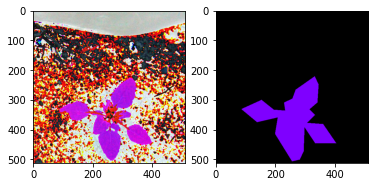

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 2):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# **Model**

## **VGG**

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
model = create_model(depth=5, 
                     start_f=256, 
                     num_classes=3)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 256)       1179904   
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 128)      

## **Unet**

In [ ]:
using_unet = False
if using_unet:
  import numpy as np 
  import os
  import skimage.io as io
  import skimage.transform as trans
  import numpy as np
  from keras.models import *
  from keras.layers import *
  from keras.optimizers import *
  from keras.callbacks import ModelCheckpoint, LearningRateScheduler
  from keras import backend as keras

  def unet(pretrained_weights = None, input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    #if pretrained_weights:
    #  model.load_weights(pretrained_weights)

    return model
    
  model = unet(input_size = (img_h,img_w,3))
  model.summary()

In [ ]:
!pip install keras_unet
from keras_unet.models import custom_unet

if using_unet:
  model = custom_unet(
      input_shape=(img_h, img_w, 3),
      use_batch_norm=True,
      num_classes=3,
      filters=32,
      dropout=0.2,
      output_activation='sigmoid')
  model.summary()

## **Compile: Loss, Optimizer, Metrics**

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

from keras import backend as K

def weighted_categorical_crossentropy():  #(1)
  W=np.zeros((img_h, img_w, 3))
  W[:,:,0]=10    # penalità falso 0 
  W[:,:,1]=1      # penalità falso 1
  W[:,:,2]=0.1  # penalità falso 2
  def wcce(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, W*y_pred)
  return wcce

def dice_coef(y_true, y_pred, smooth=1): #(2)
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return K.sqrt(2. * intersection + smooth) / K.sqrt(K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
# Compile Model
model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=metrics)
model.build(input_shape=(None, img_h, img_w, 3)) #####

## **Callbacks and Fit**

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/AN2DLsecond', 'MC_experiments',team,crop)
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
1440/1440 [==============================] - 12248s 8s/step - loss: 0.1305 - accuracy: 0.9561 - meanIoU: 0.5477 - val_loss: 0.1575 - val_accuracy: 0.9602 - val_meanIoU: 0.5835
Epoch 2/100
1440/1440 [==============================] - 10584s 7s/step - loss: 0.0450 - accuracy: 0.9833 - meanIoU: 0.7846 - val_loss: 0.2398 - val_accuracy: 0.9611 - val_meanIoU: 0.5802
Epoch 3/100
1440/1440 [==============================] - 10784s 7s/step - loss: 0.0320 - accuracy: 0.9874 - meanIoU: 0.8366 - val_loss: 0.2650 - val_accuracy: 0.9582 - val_meanIoU: 0.5466
Epoch 4/100
 124/1440 [=>............................] - ETA: 2:27:00 - loss: 0.0275 - accuracy: 0.9892 - meanIoU: 0.8567

# **Test model (facultative)**

In [ ]:
#Set experiment to use for testing 
experiment = "CNN_Dec23_02-53-21"
epoch = "2"
#Load model
model.load_weights(os.path.join('/content/drive/My Drive/AN2DLsecond/MC_experiments',team,crop,
                              experiment+'/ckpts/cp_0'+epoch+'.ckpt'))

In [ ]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

(512, 512)


(1, 512, 512, 3)

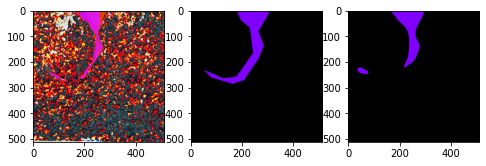

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

print(target.shape)

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 2):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 2):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

# **Prepare submission**

In [ ]:
#Set models
#teams = ["Bipbip", "Pead", "Roseau", "Weedelec"]
#crops = ["Haricot", "Mais"]

#Experiment dict: "team,crop" : [experiment,epoch]
experiment_dict = {
    "Bipbip,Haricot" : ["CNN_Dec23_13-41-43", "1"],
    "Bipbip,Mais" : ["CNN_Dec23_15-35-33", "2"],
    "Pead,Haricot" : ["CNN_Dec23_15-46-27", "1"],
    "Pead,Mais" : ["CNN_Dec23_19-58-58", "1"],
    "Roseau,Haricot" : ["CNN_Dec23_15-45-04", "1"],
    "Roseau,Mais" : ["CNN_Dec23_20-45-59", "1"],
    "Weedelec,Haricot" : ["CNN_Dec24_09-40-16", "1"],
    "Weedelec,Mais" : ["CNN_Dec24_09-40-03", "1"]
}


In [ ]:
import os
import json
import cv2
import numpy as np
from PIL import Image
import datetime

# The submission file will be a zip file containing the a
# submission.json file.

# It must have the following structure:

# - image name (without any extension, e.g., png, jpg, etc.)
#   - shape: shape of the original image as list [Height, Width]
#   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
#   - crop: crop of the original image. One in {'Haricot', 'Mais'}
#   - segmentation: prediction (as a dict)
#     - crop: RLE encoded crop segmentation (no weed)
#     - weed: RLE encoded weed segmentation (no crop)

# Please refer to the folder structure of the given dataset to fill
# the team and crop keys.

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#Set directory
directory = "/content/drive/MyDrive/AN2DLsecond/Development_Dataset/Test_Dev"

#Initialize dictionary
submission_dict = {}

#Set folders
teams = ["Bipbip", "Pead", "Roseau", "Weedelec"]
crops = ["Haricot", "Mais"]

for team in teams:
  for crop in crops:
    #Load model
    model.load_weights(os.path.join('/content/drive/My Drive/AN2DLsecond/MC_experiments',team,crop,
                                 experiment_dict[team+","+crop][0]+'/ckpts/cp_0'+experiment_dict[team+","+crop][1]+'.ckpt'))
    #Images directory
    imgs_dir = os.path.join(directory, team, crop, "Images")

    #Tiles number of nodes 
    w,h = Image.open(os.path.join(imgs_dir, os.listdir(imgs_dir)[0])).size
    y_nodes = math.floor(h/y_step)+1
    x_nodes = math.floor(w/x_step)+1

    #Iterate over the test set
    for img_name in os.listdir(imgs_dir):
      #Open image
      img = Image.open(os.path.join(imgs_dir, img_name))
      img_name = os.path.splitext(img_name)[0] #remove extension

      #Create tiles
      mask_arr = np.array([])
      for i_y in range(y_nodes):
        mask_arr_vstripe = np.array([])
        for i_x in range(x_nodes):
          #Tile coordinates
          left = max(i_x*x_step-x_overlap, 0)
          top = max(i_y*y_step-y_overlap, 0)
          right = min((i_x+1)*x_step+x_overlap, w)
          bottom = min((i_y+1)*y_step+y_overlap, h)
          if left==0:
            right+=x_overlap
          if top==0:
            bottom+=y_overlap
          if right==w:
            left=right-tiling_shape_x
          if bottom==h:
            top=bottom-tiling_shape_y
          #Create tile image
          img_tile = img.crop((left, top, right, bottom))
          #Numpy Array
          img_tile_arr = np.array(img_tile)

          #Compute prediction
          out_sigmoid = model.predict(x=tf.expand_dims(img_tile_arr, 0))
          #Resize prediction
          mask_tile_arr = tf.argmax(out_sigmoid, -1)
          mask_tile_arr = mask_tile_arr[0, ...]
          mask_tile_arr = np.array(mask_tile_arr)
          #Crop prediction
          if left==0:
            right=x_step
          elif right==w:
            right=tiling_shape_x
            left=right-w%x_step
          else:
            left=x_overlap
            right=left+x_step
          if top==0:
            bottom=y_step
          elif bottom==h:
            bottom=tiling_shape_y
            top=bottom-h%y_step
          else:
            top=y_overlap
            bottom=top+y_step
          mask_tile_arr = mask_tile_arr[int(top):int(bottom),int(left):int(right)]

          #Concatenate vertically
          if i_x==0:
            mask_arr_vstripe = mask_tile_arr
          else:
            mask_arr_vstripe = np.concatenate((mask_arr_vstripe, mask_tile_arr), axis=1)
          
        #Concatenate horizontally
        if i_y==0:
          mask_arr = mask_arr_vstripe
        else:
          mask_arr = np.concatenate((mask_arr, mask_arr_vstripe), axis=0)

      #Compute dictionary
      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = team
      submission_dict[img_name]['crop'] = crop
      submission_dict[img_name]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

    print(team, crop)

now = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
# Save the results into the submission.json file
with open('/content/drive/My Drive/AN2DLsecond/Submissions/submission_'+str(now)+'.json', 'w') as f:
    json.dump(submission_dict, f)

Bipbip Haricot


Bipbip Mais


Pead Haricot


Pead Mais


Roseau Haricot


Roseau Mais


Weedelec Haricot


Weedelec Mais
